# Item-Item Recommender System on MovieLens 32M

A step-by-step notebook that builds and evaluates item-item recommenders using implicit feedback, temporal splitting, and hyperparameter optimization.

**What you will build:**
- Baselines: `Top Popular`, `Random`
- Item-item models with SimilariPy: `Dot Product`, `RP3Beta`, `Asymmetric Cosine`
- Hyperparameter optimization with Optuna
- Final test-set comparison and recommendation examples with movie metadata
- 2D item-map visualization with UMAP

**Why SimilariPy in this notebook:**
- It computes sparse item-item similarity efficiently (Cython + OpenMP), which is useful when running hyperparameter search.
- It exposes recommender-oriented controls (`k`, `shrink`, `shrink_type`, model-specific parameters) in a consistent API.


## 0) Environment & Imports

Install dependencies if needed (uncomment the first line if you're running in a fresh environment).


In [1]:
# !pip install -U pandas numpy scipy matplotlib seaborn optuna umap-learn similaripy scikit-learn

import zipfile
from pathlib import Path
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import optuna
from optuna.importance import get_param_importances

import similaripy as sim
from sklearn.decomposition import TruncatedSVD
import umap

sns.set_theme(style="whitegrid")


### Global Configuration

Adjust these settings in one place before running the notebook:
- Temporal split windows and target strategy
- Evaluation subsampling sizes
- Optuna trial budget
- Recommendation example filters
- UMAP visualization density and label cadence


In [2]:
# Reproducibility
GLOBAL_RANDOM_SEED = 42                 # master seed for deterministic sampling where possible
np.random.seed(GLOBAL_RANDOM_SEED)

# Temporal split (global timeline)
VAL_WINDOW_MONTHS = 3                   # months in validation holdout window
TEST_WINDOW_MONTHS = 3                  # months in test holdout window
TARGET_STRATEGY = "last"                # target selection in each holdout: "last" or "random"
TARGET_RANDOM_SEED = 42                 # random seed when TARGET_STRATEGY="random"

# Preprocessing filters
MIN_USER_INTERACTIONS = 5               # iterative min interactions per user
MIN_ITEM_INTERACTIONS = 10              # iterative min interactions per item
MAX_USER_INTERACTIONS_Q = 99.5          # upper-tail cap for very active users (quantile in %)

# Evaluation subsampling (set max_users=None for full evaluation)
VAL_EVAL_MAX_USERS = 20_000             # users sampled for baseline/default validation metrics
VAL_EVAL_SAMPLE_SEED = 42               # seed for baseline/default validation sampling
OPTUNA_VAL_MAX_USERS = 5_000            # users sampled per Optuna trial (runtime control)
OPTUNA_VAL_SAMPLE_SEED = 123            # seed for Optuna validation sampling
TEST_EVAL_MAX_USERS = 30_000            # users sampled for final test metrics
TEST_EVAL_SAMPLE_SEED = 777             # seed for test sampling

# Optuna budget per model
MODELS_TO_OPTIMIZE = ["dot_product", "asymmetric_cosine", "rp3beta"]  # one study per model
OPTUNA_RANDOM_TRIALS = 10               # startup random trials before TPE
OPTUNA_TPE_TRIALS = 30                  # TPE-guided optimization trials

# Recommendation example selection
MAX_CONTEXT_ITEMS_FOR_EXAMPLE = 20      # pick a user with context length < this threshold

# UMAP visualization
UMAP_N_VIS_ITEMS = 3000                 # number of most-popular items projected
UMAP_SVD_COMPONENTS = 64                # SVD dimensionality before UMAP
UMAP_N_NEIGHBORS = 30                   # UMAP local-neighborhood size
UMAP_MIN_DIST = 0.1                     # UMAP minimum distance between embedded points
UMAP_RANDOM_SEED = 42                   # seed for UMAP and label sampling
UMAP_OLD_LABEL_CUTOFF_YEAR = 1990       # pre-cutoff labels sampled by decade
UMAP_RECENT_LABEL_BIN_YEARS = 3         # post-cutoff labels sampled per N-year bucket


## 1) Introduction

### Collaborative filtering in one paragraph
Collaborative filtering learns from interaction patterns (users x items) rather than content features. If users who liked item A also liked item B, then A and B are considered similar.

### Why item-item recommenders?
Item-item KNN methods are practical and explainable: we can recommend items similar to what a user already interacted with, and they do not require a full recomputation to serve recommendations.

### Why convert explicit ratings to implicit feedback?
In many production scenarios, we optimize ranking from *interaction signals* (click/watch/purchase), not absolute rating values. In this notebook, we convert ratings to implicit events (`1 = interaction exists`) to focus on top-N ranking.

### How SimilariPy is used here
1. Build a sparse interaction matrix `URM` (users x items), then transpose to `items x users` for item-item similarity.
2. Train a sparse similarity matrix `W` (items x items) with SimilariPy; only top-`k` neighbors are retained per item.
3. Score candidates with sparse matrix multiplication: `scores = context_profile * W`.
4. Remove seen/context items from the ranked list at inference time.

This is a classic high-throughput item-KNN pipeline used in many production recommenders.


## 2) Dataset Setup

We use a well-known dataset: MovieLens 32M (`ml-32m`). This dataset includes:
- `ratings.csv`: `userId`, `movieId`, `rating`, `timestamp`
- `movies.csv`: `movieId`, `title`, `genres`

At load time we also engineer two single-value metadata fields from titles:
- `release_year`
- `release_decade` (used later to color UMAP)

In [3]:
DATA_DIR = Path("datasets_bench")
DATA_DIR.mkdir(parents=True, exist_ok=True)

ML32M_URL = "https://files.grouplens.org/datasets/movielens/ml-32m.zip"
ML32M_ZIP = DATA_DIR / "ml-32m.zip"
ML32M_DIR = DATA_DIR / "ml-32m"


def download_and_extract_movielens_32m(url=ML32M_URL, zip_path=ML32M_ZIP, extract_dir=DATA_DIR):
    if not ML32M_DIR.exists():
        if not zip_path.exists():
            print(f"Downloading MovieLens 32M from: {url}")
            urlretrieve(url, zip_path)
            print(f"Downloaded: {zip_path}")
        else:
            print(f"Using existing zip: {zip_path}")

        print(f"Extracting to: {extract_dir}")
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(extract_dir)
        print("Extraction complete.")
    else:
        print(f"Dataset already available at: {ML32M_DIR}")


download_and_extract_movielens_32m()


Dataset already available at: datasets_bench/ml-32m


In [4]:
ratings_path = ML32M_DIR / "ratings.csv"
movies_path = ML32M_DIR / "movies.csv"

ratings = pd.read_csv(ratings_path)
movies = pd.read_csv(movies_path)

# Precompute single-value temporal metadata from title suffix "(YYYY)"
movies["release_year"] = pd.to_numeric(
    movies["title"].str.extract(r"\((\d{4})\)\s*$")[0],
    errors="coerce",
).astype("Int64")
movies["release_decade"] = ((movies["release_year"] // 10) * 10).astype("Int64")
movies["decade_label"] = np.where(
    movies["release_decade"].notna(),
    movies["release_decade"].astype(str) + "s",
    "Unknown",
)

print("ratings shape:", ratings.shape)
print("movies shape:", movies.shape)
ratings.head()


ratings shape: (32000204, 4)
movies shape: (87585, 6)


,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [5]:
# Join in simple popularity stats for a richer metadata table
movie_stats = (
    ratings.groupby("movieId")
    .agg(num_ratings=("rating", "size"), avg_rating=("rating", "mean"))
    .reset_index()
)

metadata_sample = (
    movies.merge(movie_stats, on="movieId", how="left")
    .sort_values("num_ratings", ascending=False)
    .head(15)
)
metadata_sample.head()


,movieId,title,genres,release_year,release_decade,decade_label,num_ratings,avg_rating
314,318,"Shawshank Redemption, The (1994)",Crime|Drama,1994,1990,1990s,102929.0,4.404614
351,356,Forrest Gump (1994),Comedy|Drama|Romance|War,1994,1990,1990s,100296.0,4.052744
292,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994,1990,1990s,98409.0,4.196969
2480,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999,1990,1990s,93808.0,4.156437
585,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,1991,1990,1990s,90330.0,4.148367


## 3) Data Preprocessing

Steps:
1. Deduplicate (`userId`, `movieId`) keeping the latest timestamp if a user has multiple events for the same item.
2. Convert explicit ratings to implicit interactions (`value = 1`).
3. Remove cold users/items iteratively (thresholds from Global Configuration):
   - users with fewer than `MIN_USER_INTERACTIONS`
   - items with fewer than `MIN_ITEM_INTERACTIONS`
4. Trim the most extreme power users using a quantile cap (`MAX_USER_INTERACTIONS_Q`).
5. Label encoding: convert `movieId` and `userId` into contiguous integer indices starting from 0 to create sparse matrices.


In [6]:
# 1) Deduplicate interactions by user-item pair (keep latest event)
interactions = ratings[["userId", "movieId", "timestamp"]].copy()
interactions = (
    interactions.sort_values(["userId", "movieId", "timestamp"])
    .drop_duplicates(["userId", "movieId"], keep="last")
)

# 2) Explicit -> implicit (binary)
interactions["value"] = 1.0

print("Interactions after deduplication:", len(interactions))
interactions.head()


Interactions after deduplication: 32000204


,userId,movieId,timestamp,value
0,1,17,944249077,1.0
1,1,25,944250228,1.0
2,1,29,943230976,1.0
3,1,30,944249077,1.0
4,1,32,943228858,1.0


In [7]:
def iterative_cold_filter(df, min_user_interactions=5, min_item_interactions=10):
    filtered = df.copy()
    while True:
        start_size = len(filtered)

        user_counts = filtered["userId"].value_counts()
        keep_users = user_counts[user_counts >= min_user_interactions].index
        filtered = filtered[filtered["userId"].isin(keep_users)]

        item_counts = filtered["movieId"].value_counts()
        keep_items = item_counts[item_counts >= min_item_interactions].index
        filtered = filtered[filtered["movieId"].isin(keep_items)]

        if len(filtered) == start_size:
            break

    return filtered


# Base cold-start filtering
filtered_interactions = iterative_cold_filter(
    interactions,
    min_user_interactions=MIN_USER_INTERACTIONS,
    min_item_interactions=MIN_ITEM_INTERACTIONS,
)

# Optional upper-tail user filtering
user_counts_tmp = filtered_interactions["userId"].value_counts()
max_user_interactions = int(np.percentile(user_counts_tmp, MAX_USER_INTERACTIONS_Q))
keep_users = user_counts_tmp[user_counts_tmp <= max_user_interactions].index

before_users = filtered_interactions["userId"].nunique()
before_interactions = len(filtered_interactions)

filtered_interactions = filtered_interactions[filtered_interactions["userId"].isin(keep_users)].copy()

# Re-apply minimum filters to keep consistency after trimming
filtered_interactions = iterative_cold_filter(
    filtered_interactions,
    min_user_interactions=MIN_USER_INTERACTIONS,
    min_item_interactions=MIN_ITEM_INTERACTIONS,
)

after_users = filtered_interactions["userId"].nunique()
after_interactions = len(filtered_interactions)

print(f"Power-user cap quantile: q={MAX_USER_INTERACTIONS_Q}% -> max_user_interactions={max_user_interactions:,}")
print(f"Users: {before_users:,} -> {after_users:,}")
print(f"Interactions: {before_interactions:,} -> {after_interactions:,}")
print("Unique items:", filtered_interactions['movieId'].nunique())



Power-user cap quantile: q=99.5% -> max_user_interactions=1,645
Users: 200,948 -> 199,944
Interactions: 31,842,705 -> 29,317,041
Unique items: 24790


In [8]:
# Build contiguous IDs for sparse modeling
unique_users = filtered_interactions["userId"].drop_duplicates().to_numpy()
unique_items = filtered_interactions["movieId"].drop_duplicates().to_numpy()

user_to_idx = {u: i for i, u in enumerate(unique_users)}
item_to_idx = {m: i for i, m in enumerate(unique_items)}
idx_to_user = {i: u for u, i in user_to_idx.items()}
idx_to_item = {i: m for m, i in item_to_idx.items()}

filtered_interactions["user_idx"] = filtered_interactions["userId"].map(user_to_idx).astype(np.int32)
filtered_interactions["item_idx"] = filtered_interactions["movieId"].map(item_to_idx).astype(np.int32)

n_users = len(unique_users)
n_items = len(unique_items)

print(f"n_users={n_users:,}, n_items={n_items:,}, interactions={len(filtered_interactions):,}")


n_users=199,944, n_items=24,790, interactions=29,317,041


In [9]:
# Basic stats and time distribution
user_interactions = filtered_interactions.groupby("user_idx").size()
item_interactions = filtered_interactions.groupby("item_idx").size()

ts_dt = pd.to_datetime(filtered_interactions["timestamp"], unit="s")

stats_df = pd.DataFrame({
    "metric": [
        "n_users", "n_items", "n_interactions", "density",
        "avg_interactions_per_user", "median_interactions_per_user",
        "avg_interactions_per_item", "median_interactions_per_item",
    ],
    "value": [
        n_users,
        n_items,
        len(filtered_interactions),
        len(filtered_interactions) / (n_users * n_items),
        user_interactions.mean(),
        user_interactions.median(),
        item_interactions.mean(),
        item_interactions.median(),
    ]
})
stats_df


,metric,value
0,n_users,1.999440e+05
1,n_items,2.479000e+04
2,n_interactions,2.931704e+07
3,density,5.914734e-03
4,avg_interactions_per_user,1.466263e+02
5,median_interactions_per_user,7.200000e+01
6,avg_interactions_per_item,1.182616e+03
7,median_interactions_per_item,6.400000e+01


Users: max=1,641 | p99=1,078
Items: max=101,972 | p99=21,270


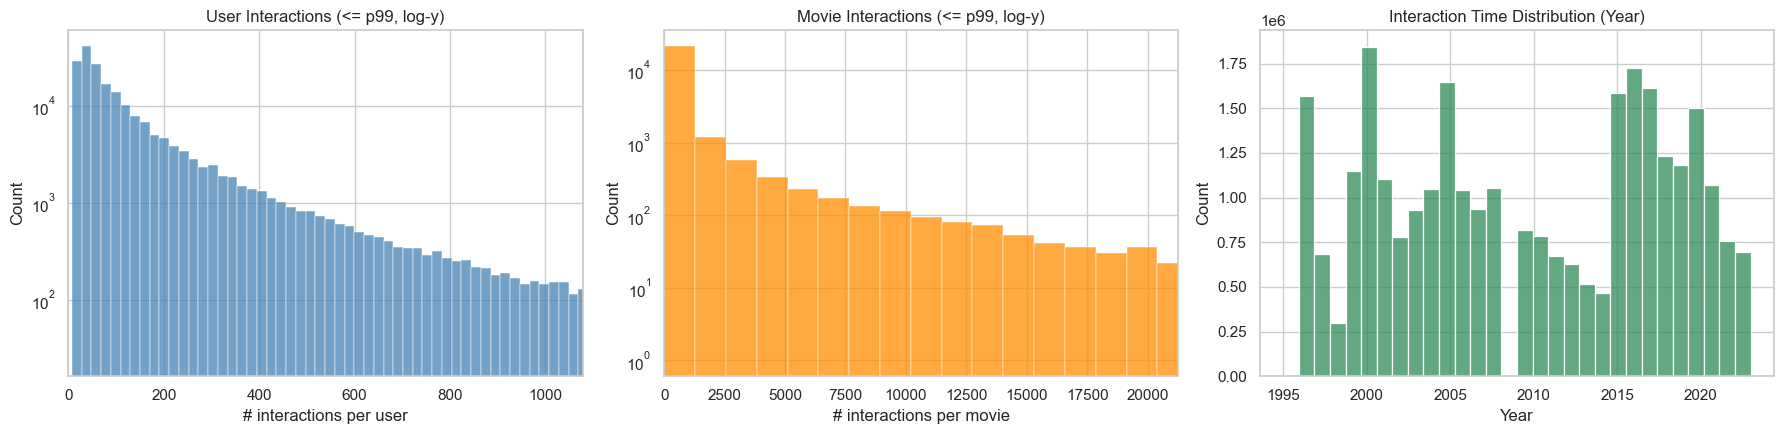

In [10]:
# Distribution diagnostics (without CCDF panels)
user_counts = user_interactions.astype(int)
item_counts = item_interactions.astype(int)

u_p99 = int(np.percentile(user_counts, 99))
i_p99 = int(np.percentile(item_counts, 99))

print(f"Users: max={user_counts.max():,} | p99={u_p99:,}")
print(f"Items: max={item_counts.max():,} | p99={i_p99:,}")

fig, axes = plt.subplots(1, 3, figsize=(18, 4.5))

# 1) Interactions per user (zoomed to p99, log-y)
sns.histplot(user_counts, bins=80, ax=axes[0], color="steelblue")
axes[0].set_yscale("log")
axes[0].set_xlim(0, max(10, u_p99))
axes[0].axvline(u_p99, ls="--", color="black", lw=1)
axes[0].set_title("User Interactions (<= p99, log-y)")
axes[0].set_xlabel("# interactions per user")

# 2) Interactions per movie (zoomed to p99, log-y)
sns.histplot(item_counts, bins=80, ax=axes[1], color="darkorange")
axes[1].set_yscale("log")
axes[1].set_xlim(0, max(10, i_p99))
axes[1].axvline(i_p99, ls="--", color="black", lw=1)
axes[1].set_title("Movie Interactions (<= p99, log-y)")
axes[1].set_xlabel("# interactions per movie")

# 3) Time distribution
sns.histplot(ts_dt.dt.year, bins=30, ax=axes[2], color="seagreen")
axes[2].set_title("Interaction Time Distribution (Year)")
axes[2].set_xlabel("Year")

plt.tight_layout()
plt.show()



## 4) Temporal Splitting

We use a **global timestamp split** (GTS) to avoid data leakage, with fixed calendar windows anchored at the latest interaction time:
- `holdout_test` = last **TEST_WINDOW_MONTHS** months (default: `3`)
- `holdout_val` = the **VAL_WINDOW_MONTHS** months before test (default: `3`)
- `train_val` = all interactions before the validation window
- `train_test` = all interactions before the test window (includes the validation period)

From each holdout window, we create **one target per user** using a configurable strategy:
- `last` (default): use the user's last holdout interaction
- `random`: sample one holdout interaction per user

At inference time for a target, we build the user context from **all interactions before that target timestamp** (including post-cutoff interactions that happened before the target), consistent with the GTS protocol.

We also report a coverage diagnostics table (holdout users, targets retained, sampled evaluation coverage, and context-length statistics) to make the protocol fully transparent.


In [11]:
# Global chronological ordering with deterministic tie-breakers
interactions_global = (
    filtered_interactions
    .sort_values(["timestamp", "user_idx", "item_idx"])
    .reset_index(drop=True)
    .copy()
)
interactions_global["event_idx"] = np.arange(len(interactions_global), dtype=np.int64)


# Fixed global windows from dataset end time
max_ts = int(interactions_global["timestamp"].max())
max_dt = pd.to_datetime(max_ts, unit="s")

test_start_dt = max_dt - pd.DateOffset(months=TEST_WINDOW_MONTHS)
val_start_dt = test_start_dt - pd.DateOffset(months=VAL_WINDOW_MONTHS)

test_cutoff_ts = int(test_start_dt.value // 10**9)
val_cutoff_ts = int(val_start_dt.value // 10**9)
assert val_cutoff_ts < test_cutoff_ts, "Validation cutoff must be before test cutoff"


train_val_df = interactions_global[interactions_global["timestamp"] <= val_cutoff_ts].copy()
holdout_val_pool = interactions_global[
    (interactions_global["timestamp"] > val_cutoff_ts)
    & (interactions_global["timestamp"] <= test_cutoff_ts)
].copy()

train_test_df = interactions_global[interactions_global["timestamp"] <= test_cutoff_ts].copy()
holdout_test_pool = interactions_global[interactions_global["timestamp"] > test_cutoff_ts].copy()

print("Dataset max timestamp:", max_dt)
print("Validation cutoff (start holdout_val):", pd.to_datetime(val_cutoff_ts, unit="s"))
print("Test cutoff (start holdout_test):", pd.to_datetime(test_cutoff_ts, unit="s"))
print("train_val interactions:", len(train_val_df))
print("holdout_val interactions:", len(holdout_val_pool))
print("train_test interactions:", len(train_test_df))
print("holdout_test interactions:", len(holdout_test_pool))


Dataset max timestamp: 2023-10-13 02:23:19
Validation cutoff (start holdout_val): 2023-04-13 02:23:19
Test cutoff (start holdout_test): 2023-07-13 02:23:19
train_val interactions: 28875891
holdout_val interactions: 189939
train_test interactions: 29065830
holdout_test interactions: 251211


In [12]:
# Global temporal leakage checks
if len(holdout_val_pool) > 0 and len(train_val_df) > 0:
    assert train_val_df["timestamp"].max() <= holdout_val_pool["timestamp"].min(), "TrainVal/HoldoutVal leakage"

if len(holdout_test_pool) > 0 and len(train_test_df) > 0:
    assert train_test_df["timestamp"].max() <= holdout_test_pool["timestamp"].min(), "TrainTest/HoldoutTest leakage"

assert train_val_df["timestamp"].max() <= train_test_df["timestamp"].max(), "Cutoff ordering mismatch"

print("Global temporal leakage checks passed.")

split_ranges_df = pd.DataFrame([
    {
        "split": "train_val",
        "start": pd.to_datetime(train_val_df["timestamp"].min(), unit="s") if len(train_val_df) else pd.NaT,
        "end": pd.to_datetime(train_val_df["timestamp"].max(), unit="s") if len(train_val_df) else pd.NaT,
        "interactions": int(len(train_val_df)),
        "users": int(train_val_df["user_idx"].nunique()),
        "items": int(train_val_df["item_idx"].nunique()),
    },
    {
        "split": "holdout_val",
        "start": pd.to_datetime(holdout_val_pool["timestamp"].min(), unit="s") if len(holdout_val_pool) else pd.NaT,
        "end": pd.to_datetime(holdout_val_pool["timestamp"].max(), unit="s") if len(holdout_val_pool) else pd.NaT,
        "interactions": int(len(holdout_val_pool)),
        "users": int(holdout_val_pool["user_idx"].nunique()),
        "items": int(holdout_val_pool["item_idx"].nunique()),
    },
    {
        "split": "train_test",
        "start": pd.to_datetime(train_test_df["timestamp"].min(), unit="s") if len(train_test_df) else pd.NaT,
        "end": pd.to_datetime(train_test_df["timestamp"].max(), unit="s") if len(train_test_df) else pd.NaT,
        "interactions": int(len(train_test_df)),
        "users": int(train_test_df["user_idx"].nunique()),
        "items": int(train_test_df["item_idx"].nunique()),
    },
    {
        "split": "holdout_test",
        "start": pd.to_datetime(holdout_test_pool["timestamp"].min(), unit="s") if len(holdout_test_pool) else pd.NaT,
        "end": pd.to_datetime(holdout_test_pool["timestamp"].max(), unit="s") if len(holdout_test_pool) else pd.NaT,
        "interactions": int(len(holdout_test_pool)),
        "users": int(holdout_test_pool["user_idx"].nunique()),
        "items": int(holdout_test_pool["item_idx"].nunique()),
    },
])

split_ranges_df


Global temporal leakage checks passed.


,split,start,end,interactions,users,items
0,train_val,1995-01-09 11:46:44,2023-04-13 02:23:08,28875891,197813,24704
1,holdout_val,2023-04-13 02:23:20,2023-07-13 02:22:30,189939,4104,12244
2,train_test,1995-01-09 11:46:44,2023-07-13 02:22:30,29065830,198742,24758
3,holdout_test,2023-07-13 02:24:35,2023-10-13 02:23:19,251211,4449,14212


In [13]:
def df_to_csr(df, n_users, n_items):
    return sp.csr_matrix(
        (
            np.ones(len(df), dtype=np.float32),
            (df["user_idx"].to_numpy(), df["item_idx"].to_numpy()),
        ),
        shape=(n_users, n_items),
        dtype=np.float32,
    )


def build_single_target_table(
    interactions_sorted,
    holdout_pool,
    train_item_mask,
    target_strategy="last",
    random_seed=42,
):
    # Build one target per user from holdout_pool using `last` or `random`.
    # Context for each target includes all user interactions before target event_idx,
    # filtered to items known in training (train_item_mask).
    if target_strategy not in {"last", "random"}:
        raise ValueError("target_strategy must be one of {'last', 'random'}")

    if len(holdout_pool) == 0:
        return pd.DataFrame(
            columns=[
                "user_idx", "target_item_idx", "target_event_idx", "target_timestamp",
                "context_items", "n_context_items"
            ]
        )

    rng = np.random.default_rng(random_seed)
    selected_rows = []

    for user_idx, grp in holdout_pool.groupby("user_idx", sort=False):
        grp = grp.sort_values("event_idx")
        if target_strategy == "last":
            target_row = grp.iloc[-1]
        else:  # random
            target_row = grp.iloc[int(rng.integers(0, len(grp)))]
        selected_rows.append(target_row)

    targets_raw = pd.DataFrame(selected_rows).reset_index(drop=True)
    target_users = targets_raw["user_idx"].unique()

    history_map = {}
    subset = interactions_sorted[interactions_sorted["user_idx"].isin(target_users)]
    for user_idx, grp in subset.groupby("user_idx", sort=False):
        grp = grp.sort_values("event_idx")
        history_map[int(user_idx)] = (
            grp["event_idx"].to_numpy(dtype=np.int64),
            grp["item_idx"].to_numpy(dtype=np.int32),
        )

    final_rows = []
    for row in targets_raw.itertuples(index=False):
        user_idx = int(row.user_idx)
        target_item_idx = int(row.item_idx)
        target_event_idx = int(row.event_idx)
        target_timestamp = int(row.timestamp)

        if target_item_idx >= len(train_item_mask) or not train_item_mask[target_item_idx]:
            continue

        event_arr, item_arr = history_map[user_idx]
        pos = np.searchsorted(event_arr, target_event_idx, side="left")
        context_items = item_arr[:pos]

        if len(context_items) > 0:
            context_items = context_items[train_item_mask[context_items]]

        final_rows.append(
            {
                "user_idx": user_idx,
                "target_item_idx": target_item_idx,
                "target_event_idx": target_event_idx,
                "target_timestamp": target_timestamp,
                "context_items": context_items.astype(np.int32, copy=False),
                "n_context_items": int(len(context_items)),
            }
        )

    return pd.DataFrame(final_rows)


URM_train_val = df_to_csr(train_val_df, n_users, n_items)
URM_train_test = df_to_csr(train_test_df, n_users, n_items)

print("URM_train_val:", URM_train_val.shape, "nnz=", URM_train_val.nnz)
print("URM_train_test:", URM_train_test.shape, "nnz=", URM_train_test.nnz)


# Choose target protocol from global config

train_item_mask_val = np.zeros(n_items, dtype=bool)
train_item_mask_val[train_val_df["item_idx"].unique()] = True

train_item_mask_test = np.zeros(n_items, dtype=bool)
train_item_mask_test[train_test_df["item_idx"].unique()] = True

# Draw targets once and reuse them for all tuning/evaluation calls.
val_targets_all = build_single_target_table(
    interactions_sorted=interactions_global,
    holdout_pool=holdout_val_pool,
    train_item_mask=train_item_mask_val,
    target_strategy=TARGET_STRATEGY,
    random_seed=TARGET_RANDOM_SEED,
)

test_targets_all = build_single_target_table(
    interactions_sorted=interactions_global,
    holdout_pool=holdout_test_pool,
    train_item_mask=train_item_mask_test,
    target_strategy=TARGET_STRATEGY,
    random_seed=TARGET_RANDOM_SEED,
)

print("Target strategy:", TARGET_STRATEGY)
print("Validation targets:", len(val_targets_all))
print("Test targets:", len(test_targets_all))
if len(val_targets_all):
    print("Avg val context length:", round(val_targets_all["n_context_items"].mean(), 2))
if len(test_targets_all):
    print("Avg test context length:", round(test_targets_all["n_context_items"].mean(), 2))

# Coverage diagnostics for the fixed 3M windows
# With one target per user, `targets == users_with_target` by construction.

METRIC_K_FOR_CONTEXT = 10


def _coverage_row(target_set, holdout_pool, targets_all, eval_max_users, metric_k=10):
    users_in_holdout = int(holdout_pool["user_idx"].nunique())
    users_with_target = int(targets_all["user_idx"].nunique())
    targets_total = int(len(targets_all))

    targets_sampled = (
        min(targets_total, int(eval_max_users))
        if eval_max_users is not None
        else targets_total
    )

    if targets_total > 0:
        ctx = targets_all["n_context_items"].astype(int)
        avg_ctx = float(ctx.mean())
        med_ctx = float(ctx.median())
        p10_ctx = float(np.percentile(ctx, 10))
        p90_ctx = float(np.percentile(ctx, 90))
        pct_ctx_lt_k = float((ctx < metric_k).mean())
        pct_ctx_eq_0 = float((ctx == 0).mean())
    else:
        avg_ctx = med_ctx = p10_ctx = p90_ctx = np.nan
        pct_ctx_lt_k = pct_ctx_eq_0 = np.nan

    return {
        "target_set": target_set,
        "users_in_holdout": users_in_holdout,
        "users_with_target": users_with_target,
        "users_without_target": max(users_in_holdout - users_with_target, 0),
        "targets_total": targets_total,
        "targets_sampled_for_eval": int(targets_sampled),
        "target_rate_vs_holdout_users": (users_with_target / users_in_holdout) if users_in_holdout else np.nan,
        "sampled_rate_vs_targets": (targets_sampled / targets_total) if targets_total else np.nan,
        "avg_context_len": avg_ctx,
        "median_context_len": med_ctx,
        "p10_context_len": p10_ctx,
        "p90_context_len": p90_ctx,
        f"pct_context_lt_{metric_k}": pct_ctx_lt_k,
        "pct_context_eq_0": pct_ctx_eq_0,
    }


coverage_df = pd.DataFrame([
    _coverage_row(
        "validation",
        holdout_val_pool,
        val_targets_all,
        eval_max_users=VAL_EVAL_MAX_USERS,
        metric_k=METRIC_K_FOR_CONTEXT,
    ),
    _coverage_row(
        "test",
        holdout_test_pool,
        test_targets_all,
        eval_max_users=TEST_EVAL_MAX_USERS,
        metric_k=METRIC_K_FOR_CONTEXT,
    ),
])

coverage_df = coverage_df.assign(
    target_rate_vs_holdout_users=coverage_df["target_rate_vs_holdout_users"].round(4),
    sampled_rate_vs_targets=coverage_df["sampled_rate_vs_targets"].round(4),
    avg_context_len=coverage_df["avg_context_len"].round(2),
    median_context_len=coverage_df["median_context_len"].round(2),
    p10_context_len=coverage_df["p10_context_len"].round(2),
    p90_context_len=coverage_df["p90_context_len"].round(2),
)

coverage_df


URM_train_val: (199944, 24790) nnz= 28875891
URM_train_test: (199944, 24790) nnz= 29065830
Target strategy: last
Validation targets: 3893
Test targets: 4154
Avg val context length: 399.82
Avg test context length: 398.97


,target_set,users_in_holdout,users_with_target,users_without_target,targets_total,targets_sampled_for_eval,target_rate_vs_holdout_users,sampled_rate_vs_targets,avg_context_len,median_context_len,p10_context_len,p90_context_len,pct_context_lt_10,pct_context_eq_0
0,validation,4104,3893,211,3893,3893,0.9486,1.0,399.82,260.0,45.0,1001.0,0.001798,0.000257
1,test,4449,4154,295,4154,4154,0.9337,1.0,398.97,258.5,42.0,1014.4,0.000000,0.000000


## 5) Baselines

We evaluate two simple baselines under the same GTS target protocol:
- **Top Popular**: same ranked list for everyone (excluding seen/context items)
- **Random**: random unseen items

Metrics:
- **NDCG@10** (main)
- **Recall@10**, **Precision@10** (optional)



In [14]:
def sample_targets(target_df, max_users=None, seed=42):
    if max_users is None or len(target_df) <= max_users:
        return target_df.reset_index(drop=True)
    rng = np.random.default_rng(seed)
    idx = rng.choice(target_df.index.to_numpy(), size=max_users, replace=False)
    return target_df.loc[np.sort(idx)].reset_index(drop=True)


def metrics_single_target_at_k(recommended_items, target_item, k=10):
    recs = recommended_items[:k]
    hit = float(target_item in recs)

    if hit:
        rank = recs.index(target_item) + 1
        ndcg = 1.0 / np.log2(rank + 1.0)
    else:
        ndcg = 0.0

    precision = hit / k
    recall = hit
    return precision, recall, ndcg


def evaluate_recommender_on_targets(recommend_fn, targets_df, k=10):
    precision_list = []
    recall_list = []
    ndcg_list = []

    for row in targets_df.itertuples(index=False):
        user_id = int(row.user_idx)
        context_items = row.context_items
        target_item = int(row.target_item_idx)

        recs = recommend_fn(user_id, context_items, k)
        p, r, n = metrics_single_target_at_k(recs, target_item, k=k)

        precision_list.append(p)
        recall_list.append(r)
        ndcg_list.append(n)

    return {
        "n_users": len(ndcg_list),
        "Precision@10": float(np.mean(precision_list)) if precision_list else np.nan,
        "Recall@10": float(np.mean(recall_list)) if recall_list else np.nan,
        "NDCG@10": float(np.mean(ndcg_list)) if ndcg_list else np.nan,
    }


def build_popularity_ranking(URM_train):
    item_popularity = np.asarray(URM_train.sum(axis=0)).ravel()
    popular_items = np.argsort(-item_popularity)
    return item_popularity, popular_items


def recommend_top_pop_from_ranking(popular_items, seen_items, k=10):
    seen_set = set(np.asarray(seen_items).tolist())
    recs = []
    for item in popular_items:
        if item not in seen_set:
            recs.append(int(item))
        if len(recs) == k:
            break
    return recs


def recommend_random(user_id, seen_items, k=10, seed=42):
    rng = np.random.default_rng(seed + int(user_id))
    seen_set = set(np.asarray(seen_items).tolist())
    recs = []
    rec_set = set()

    while len(recs) < k:
        item = int(rng.integers(0, n_items))
        if item in seen_set or item in rec_set:
            continue
        recs.append(item)
        rec_set.add(item)
    return recs



In [15]:
val_targets_eval = sample_targets(val_targets_all, max_users=VAL_EVAL_MAX_USERS, seed=VAL_EVAL_SAMPLE_SEED)

item_popularity_val, popular_items_val = build_popularity_ranking(URM_train_val)

baseline_results = []

res_top_pop = evaluate_recommender_on_targets(
    lambda u, seen, k: recommend_top_pop_from_ranking(popular_items_val, seen, k),
    val_targets_eval,
    k=10,
)
res_top_pop["model"] = "Top Popular"
baseline_results.append(res_top_pop)

res_random = evaluate_recommender_on_targets(
    lambda u, seen, k: recommend_random(u, seen, k, seed=42),
    val_targets_eval,
    k=10,
)
res_random["model"] = "Random"
baseline_results.append(res_random)

baseline_df = pd.DataFrame(baseline_results)[["model", "n_users", "Precision@10", "Recall@10", "NDCG@10"]]
baseline_df



,model,n_users,Precision@10,Recall@10,NDCG@10
0,Top Popular,3893,0.002389,0.023889,0.012370
1,Random,3893,0.000077,0.000771,0.000547


## 6) Item-Item Algorithms (SimilariPy)

We train three item-item models on `URM_train_val`:
1. `dot_product`
2. `rp3beta`
3. `asymmetric_cosine`

For each target event, we score items from the target context profile in **bulk** using SimilariPy:
`scores = sim.dot_product(context_matrix, W, target_rows=..., filter_cols=context_matrix)`.

This uses:
- `target_rows` to score only requested users in each batch
- `filter_cols` (row-wise sparse mask) to remove seen/context items directly inside SimilariPy

### What each model captures
- `dot_product`: raw co-occurrence strength. Items frequently consumed together get high similarity.
- `asymmetric_cosine`: cosine-like normalization with directional bias (`alpha`) so source and candidate norms are weighted differently (`alpha = 0.5` is equivalent to cosine).
- `rp3beta`: graph/random-walk similarity (length-3 paths) with popularity penalization (`beta`) to reduce domination by blockbuster items (`beta = 0` is equivalent to p3alpha).

### Shared pre-processing option for all models
Before similarity computation, we optionally normalize the item-user matrix with:
- `none`
- `bm25`
- `tfidf`


In [16]:
NORMALIZATION_OPTIONS = ("none", "bm25", "tfidf")


def apply_interaction_normalization(item_user_matrix, normalization="none"):
    if normalization not in NORMALIZATION_OPTIONS:
        raise ValueError(f"Unknown normalization='{normalization}'")

    if normalization == "none":
        return item_user_matrix.tocsr()
    if normalization == "bm25":
        return sim.bm25(item_user_matrix, axis=1, inplace=False).tocsr()
    if normalization == "tfidf":
        return sim.tfidf(item_user_matrix, axis=1, inplace=False).tocsr()

    raise ValueError(f"Unhandled normalization='{normalization}'")


def train_item_similarity(model_name, item_user_matrix, k=200, shrink=10.0, shrink_type="stabilized", alpha=0.5, beta=0.6):
    if model_name == "dot_product":
        W = sim.dot_product(
            item_user_matrix,
            k=int(k),
            shrink=float(shrink),
            shrink_type=shrink_type,
            verbose=False,
            format_output="csr",
        )
    elif model_name == "rp3beta":
        W = sim.rp3beta(
            item_user_matrix,
            alpha=float(alpha),
            beta=float(beta),
            k=int(k),
            shrink=float(shrink),
            shrink_type=shrink_type,
            verbose=False,
            format_output="csr",
        )
    elif model_name == "asymmetric_cosine":
        W = sim.asymmetric_cosine(
            item_user_matrix,
            alpha=float(alpha),
            k=int(k),
            shrink=float(shrink),
            shrink_type=shrink_type,
            verbose=False,
            format_output="csr",
        )
    else:
        raise ValueError(f"Unknown model_name={model_name}")

    # Keep self-similarity diagonal; seen-item filtering is applied at ranking time.
    return W.tocsr()


def _build_context_matrix(contexts, n_items):
    rows, cols, data = [], [], []
    for r, context in enumerate(contexts):
        context = np.asarray(context, dtype=np.int32)
        if len(context) == 0:
            continue
        rows.extend([r] * len(context))
        cols.extend(context.tolist())
        data.extend([1.0] * len(context))

    return sp.csr_matrix(
        (data, (rows, cols)),
        shape=(len(contexts), n_items),
        dtype=np.float32,
    )


def _topk_from_sparse_row(indices, data, k, fallback_items, forbidden_items=None):
    if forbidden_items is None:
        forbidden_set = set()
    else:
        forbidden_set = set(np.asarray(forbidden_items, dtype=np.int32).tolist())

    if len(indices) == 0:
        recs = []
    else:
        cand_idx = np.asarray(indices, dtype=np.int32)
        cand_val = np.asarray(data, dtype=np.float32)

        if len(cand_idx) > k:
            part = np.argpartition(cand_val, -k)[-k:]
            cand_idx = cand_idx[part]
            cand_val = cand_val[part]

        order = np.argsort(-cand_val)
        recs = cand_idx[order].tolist()

    if len(recs) < k:
        rec_set = set(recs)
        for item in fallback_items:
            item = int(item)
            if item in rec_set or item in forbidden_set:
                continue
            recs.append(item)
            if len(recs) == k:
                break

    return recs[:k]


def evaluate_sparse_item_model_on_targets(W, targets_df, k=10, batch_size=1024, fallback_items=None):
    if fallback_items is None:
        fallback_items = np.argsort(-np.asarray(W.sum(axis=0)).ravel())

    precision_list, recall_list, ndcg_list = [], [], []

    for start in range(0, len(targets_df), batch_size):
        batch = targets_df.iloc[start:start + batch_size].reset_index(drop=True)
        contexts = batch["context_items"].tolist()

        # Build row-wise user context matrix for the current batch.
        X_batch = _build_context_matrix(contexts, n_items=W.shape[0])
        active_rows = np.flatnonzero(np.diff(X_batch.indptr) > 0).astype(np.int32)

        if len(active_rows) > 0:
            # Bulk recommendation scoring in Similaripy.
            # - target_rows: compute only rows with non-empty context
            # - filter_cols: row-wise seen-item filtering
            scores_batch = sim.dot_product(
                X_batch,
                W,
                k=int(k),
                target_rows=active_rows,
                filter_cols=X_batch,
                verbose=False,
                format_output="csr",
            ).tocsr()
        else:
            scores_batch = sp.csr_matrix((len(batch), W.shape[0]), dtype=np.float32)

        for local_row, row in enumerate(batch.itertuples(index=False)):
            seen_items = np.asarray(row.context_items, dtype=np.int32)
            target_item = int(row.target_item_idx)

            row_start, row_end = scores_batch.indptr[local_row], scores_batch.indptr[local_row + 1]
            row_idx = scores_batch.indices[row_start:row_end]
            row_val = scores_batch.data[row_start:row_end]

            recs = _topk_from_sparse_row(
                row_idx,
                row_val,
                k=k,
                fallback_items=fallback_items,
                forbidden_items=seen_items,
            )
            p, r, n = metrics_single_target_at_k(recs, target_item, k=k)

            precision_list.append(p)
            recall_list.append(r)
            ndcg_list.append(n)

    return {
        "n_users": len(ndcg_list),
        "Precision@10": float(np.mean(precision_list)) if precision_list else np.nan,
        "Recall@10": float(np.mean(recall_list)) if recall_list else np.nan,
        "NDCG@10": float(np.mean(ndcg_list)) if ndcg_list else np.nan,
    }


In [17]:
item_user_train_val_raw = URM_train_val.T.tocsr()
item_user_train_val_by_norm = {
    norm_name: apply_interaction_normalization(item_user_train_val_raw, norm_name)
    for norm_name in NORMALIZATION_OPTIONS
}

default_models = {
    "dot_product": {"normalization": "none", "k": 200, "shrink": 20.0, "shrink_type": "stabilized"},
    "rp3beta": {"normalization": "none", "k": 200, "shrink": 0.0, "shrink_type": "stabilized", "alpha": 0.8, "beta": 0.6},
    "asymmetric_cosine": {"normalization": "none", "k": 200, "shrink": 20.0, "shrink_type": "stabilized", "alpha": 0.4},
}

item_item_results = []
trained_default_models = {}

for model_name, param_dict in default_models.items():
    params = param_dict.copy()
    normalization = params.pop("normalization", "none")
    train_matrix = item_user_train_val_by_norm[normalization]

    W = train_item_similarity(model_name, train_matrix, **params)
    trained_default_models[model_name] = W

    metrics = evaluate_sparse_item_model_on_targets(
        W,
        targets_df=val_targets_eval,
        k=10,
        batch_size=1024,
        fallback_items=popular_items_val,
    )
    metrics["model"] = model_name
    item_item_results.append(metrics)

item_item_df = pd.DataFrame(item_item_results)[["model", "n_users", "Precision@10", "Recall@10", "NDCG@10"]]
item_item_df.sort_values("NDCG@10", ascending=False)



,model,n_users,Precision@10,Recall@10,NDCG@10
1,rp3beta,3893,0.004444,0.044439,0.023446
2,asymmetric_cosine,3893,0.003545,0.035448,0.017453
0,dot_product,3893,0.003057,0.030568,0.016790


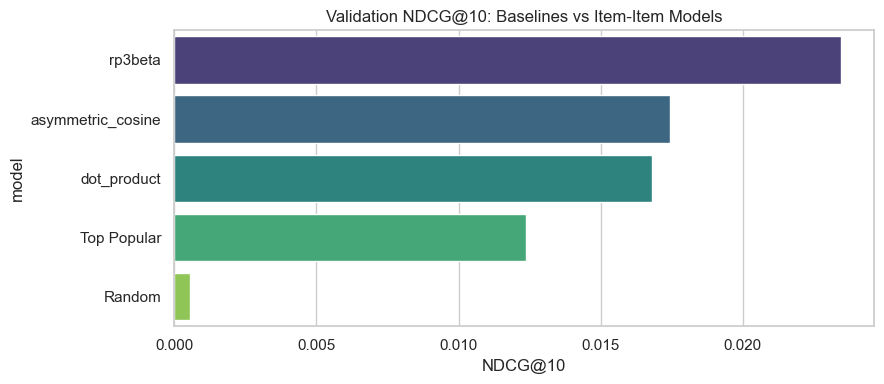

In [18]:
# Quick visual comparison vs baselines on validation
val_compare_df = pd.concat([
    baseline_df[["model", "NDCG@10"]],
    item_item_df[["model", "NDCG@10"]],
], ignore_index=True).sort_values("NDCG@10", ascending=False)

plt.figure(figsize=(9, 4))
sns.barplot(data=val_compare_df, x="NDCG@10", y="model", hue="model", palette="viridis", dodge=False, legend=False)
plt.title("Validation NDCG@10: Baselines vs Item-Item Models")
plt.tight_layout()
plt.show()



## 7) Hyperparameter Optimization (Optuna)

We run **three separate Optuna studies** (one per similarity):
- `dot_product`
- `asymmetric_cosine`
- `rp3beta`

Each study uses TPE with a configurable budget (defaults):
- `OPTUNA_RANDOM_TRIALS = 10` startup random trials
- `OPTUNA_TPE_TRIALS = 30` optimization trials
- `40` total trials per model

Search space includes:
- common: `normalization` (`NORMALIZATION_OPTIONS`), `k`, `shrink`, `shrink_type`
- model-specific:
  - `asymmetric_cosine`: `alpha`
  - `rp3beta`: `alpha`, `beta`

Objective: maximize **Validation NDCG@10** on GTS targets (`last/random`).


In [19]:
# Keep tuning practical; set to None for full validation targets.
VAL_TARGETS_OPTUNA = sample_targets(val_targets_all, max_users=OPTUNA_VAL_MAX_USERS, seed=OPTUNA_VAL_SAMPLE_SEED)

N_RANDOM_TRIALS = OPTUNA_RANDOM_TRIALS
N_OPT_TRIALS = OPTUNA_TPE_TRIALS
N_TRIALS_PER_MODEL = N_RANDOM_TRIALS + N_OPT_TRIALS

# Optuna search-space configuration (range/step/type)
OPTUNA_SPACE_COMMON = {
    "normalization": {
        "type": "categorical",
        "choices": list(NORMALIZATION_OPTIONS),
    },
    "k": {
        "type": "int",
        "low": 50,
        "high": 500,
    },
    "shrink": {
        "type": "int",
        "low": 0,
        "high": 500,
    },
    "shrink_type": {
        "type": "categorical",
        "choices": ["stabilized", "bayesian", "additive"],
    },
}

OPTUNA_SPACE_MODEL = {
    "asymmetric_cosine": {
        "asym_alpha": {
            "type": "float",
            "low": 0.1,
            "high": 0.9,
            "step": 0.05,
        },
    },
    "rp3beta": {
        "rp3_alpha": {
            "type": "float",
            "low": 0.3,
            "high": 1.5,
            "step": 0.05,
        },
        "rp3_beta": {
            "type": "float",
            "low": 0.0,
            "high": 1.5,
            "step": 0.05,
        },
    },
}


def suggest_model_params(trial, model_name):
    params = {
        "normalization": trial.suggest_categorical("normalization", OPTUNA_SPACE_COMMON["normalization"]["choices"]),
        "k": trial.suggest_int("k", OPTUNA_SPACE_COMMON["k"]["low"], OPTUNA_SPACE_COMMON["k"]["high"]),
        "shrink": trial.suggest_int("shrink", OPTUNA_SPACE_COMMON["shrink"]["low"], OPTUNA_SPACE_COMMON["shrink"]["high"]),
        "shrink_type": trial.suggest_categorical("shrink_type", OPTUNA_SPACE_COMMON["shrink_type"]["choices"]),
    }

    if model_name == "asymmetric_cosine":
        cfg = OPTUNA_SPACE_MODEL["asymmetric_cosine"]["asym_alpha"]
        params["alpha"] = trial.suggest_float("asym_alpha", cfg["low"], cfg["high"], step=cfg["step"])
    elif model_name == "rp3beta":
        cfg_a = OPTUNA_SPACE_MODEL["rp3beta"]["rp3_alpha"]
        cfg_b = OPTUNA_SPACE_MODEL["rp3beta"]["rp3_beta"]
        params["alpha"] = trial.suggest_float("rp3_alpha", cfg_a["low"], cfg_a["high"], step=cfg_a["step"])
        params["beta"] = trial.suggest_float("rp3_beta", cfg_b["low"], cfg_b["high"], step=cfg_b["step"])

    return params


def make_objective(model_name):
    def objective(trial):
        params = suggest_model_params(trial, model_name)
        normalization = params.pop("normalization")

        train_matrix = item_user_train_val_by_norm[normalization]
        W = train_item_similarity(model_name, train_matrix, **params)

        metrics = evaluate_sparse_item_model_on_targets(
            W,
            targets_df=VAL_TARGETS_OPTUNA,
            k=10,
            batch_size=1024,
            fallback_items=popular_items_val,
        )

        ndcg = metrics["NDCG@10"]
        trial.set_user_attr("model", model_name)
        trial.set_user_attr("normalization", normalization)
        trial.set_user_attr("val_precision", metrics["Precision@10"])
        trial.set_user_attr("val_recall", metrics["Recall@10"])

        return ndcg

    return objective


studies_by_model = {}

for idx, model_name in enumerate(MODELS_TO_OPTIMIZE):
    print(f"\n=== Optimizing {model_name} ===")
    sampler = optuna.samplers.TPESampler(seed=42 + idx, n_startup_trials=N_RANDOM_TRIALS)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(make_objective(model_name), n_trials=N_TRIALS_PER_MODEL, show_progress_bar=True)

    studies_by_model[model_name] = study
    print("Best trial:", study.best_trial.number)
    print("Best validation NDCG@10:", round(study.best_value, 6))
    print("Best params:", study.best_params)



[I 2026-02-23 12:32:04,569] A new study created in memory with name: no-name-e37cb8fd-efd0-4548-bbc4-77a624dded80



=== Optimizing dot_product ===


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2026-02-23 12:32:07,644] Trial 0 finished with value: 0.015357888350460057 and parameters: {'normalization': 'bm25', 'k': 319, 'shrink': 78, 'shrink_type': 'additive'}. Best is trial 0 with value: 0.015357888350460057.
[I 2026-02-23 12:32:11,257] Trial 1 finished with value: 0.015532789275634042 and parameters: {'normalization': 'bm25', 'k': 487, 'shrink': 417, 'shrink_type': 'stabilized'}. Best is trial 1 with value: 0.015532789275634042.
[I 2026-02-23 12:32:14,369] Trial 2 finished with value: 0.015596909281385143 and parameters: {'normalization': 'bm25', 'k': 181, 'shrink': 306, 'shrink_type': 'additive'}. Best is trial 2 with value: 0.015596909281385143.
[I 2026-02-23 12:32:17,506] Trial 3 finished with value: 0.012369687961811556 and parameters: {'normalization': 'bm25', 'k': 281, 'shrink': 296, 'shrink_type': 'bayesian'}. Best is trial 2 with value: 0.015596909281385143.
[I 2026-02-23 12:32:20,588] Trial 4 finished with value: 0.012369687961811556 and parameters: {'normalizati

[I 2026-02-23 12:34:03,490] A new study created in memory with name: no-name-1681e6a2-58df-4b07-8add-44b528360559


[I 2026-02-23 12:34:03,488] Trial 39 finished with value: 0.015664810126020473 and parameters: {'normalization': 'bm25', 'k': 307, 'shrink': 80, 'shrink_type': 'additive'}. Best is trial 33 with value: 0.01730017962069351.
Best trial: 33
Best validation NDCG@10: 0.0173
Best params: {'normalization': 'tfidf', 'k': 211, 'shrink': 7, 'shrink_type': 'additive'}

=== Optimizing asymmetric_cosine ===


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2026-02-23 12:34:06,525] Trial 0 finished with value: 0.020268784257742586 and parameters: {'normalization': 'bm25', 'k': 158, 'shrink': 163, 'shrink_type': 'stabilized', 'asym_alpha': 0.1}. Best is trial 0 with value: 0.020268784257742586.
[I 2026-02-23 12:34:09,602] Trial 1 finished with value: 0.01857819361118092 and parameters: {'normalization': 'tfidf', 'k': 164, 'shrink': 28, 'shrink_type': 'stabilized', 'asym_alpha': 0.35}. Best is trial 0 with value: 0.020268784257742586.
[I 2026-02-23 12:34:13,058] Trial 2 finished with value: 0.008035026528699717 and parameters: {'normalization': 'tfidf', 'k': 488, 'shrink': 193, 'shrink_type': 'stabilized', 'asym_alpha': 0.15000000000000002}. Best is trial 0 with value: 0.020268784257742586.
[I 2026-02-23 12:34:15,909] Trial 3 finished with value: 0.019961136074028434 and parameters: {'normalization': 'none', 'k': 52, 'shrink': 272, 'shrink_type': 'additive', 'asym_alpha': 0.85}. Best is trial 0 with value: 0.020268784257742586.
[I 2026-0

[I 2026-02-23 12:36:14,836] A new study created in memory with name: no-name-e5fc6206-8dde-4157-bdae-7582d5626784


[I 2026-02-23 12:36:14,834] Trial 39 finished with value: 0.005161576360247308 and parameters: {'normalization': 'tfidf', 'k': 465, 'shrink': 185, 'shrink_type': 'additive', 'asym_alpha': 0.1}. Best is trial 33 with value: 0.022064028246899216.
Best trial: 33
Best validation NDCG@10: 0.022064
Best params: {'normalization': 'bm25', 'k': 500, 'shrink': 323, 'shrink_type': 'additive', 'asym_alpha': 0.35}

=== Optimizing rp3beta ===


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2026-02-23 12:36:18,155] Trial 0 finished with value: 0.011171216903910309 and parameters: {'normalization': 'none', 'k': 212, 'shrink': 180, 'shrink_type': 'stabilized', 'rp3_alpha': 0.9000000000000001, 'rp3_beta': 1.1}. Best is trial 0 with value: 0.011171216903910309.
[I 2026-02-23 12:36:21,148] Trial 1 finished with value: 0.02128851847112432 and parameters: {'normalization': 'none', 'k': 101, 'shrink': 109, 'shrink_type': 'stabilized', 'rp3_alpha': 1.1, 'rp3_beta': 0.30000000000000004}. Best is trial 1 with value: 0.02128851847112432.
[I 2026-02-23 12:36:24,326] Trial 2 finished with value: 0.02082015831248536 and parameters: {'normalization': 'none', 'k': 444, 'shrink': 129, 'shrink_type': 'bayesian', 'rp3_alpha': 1.0, 'rp3_beta': 0.2}. Best is trial 1 with value: 0.02128851847112432.
[I 2026-02-23 12:36:27,559] Trial 3 finished with value: 0.019556373465887844 and parameters: {'normalization': 'tfidf', 'k': 255, 'shrink': 398, 'shrink_type': 'stabilized', 'rp3_alpha': 0.90000

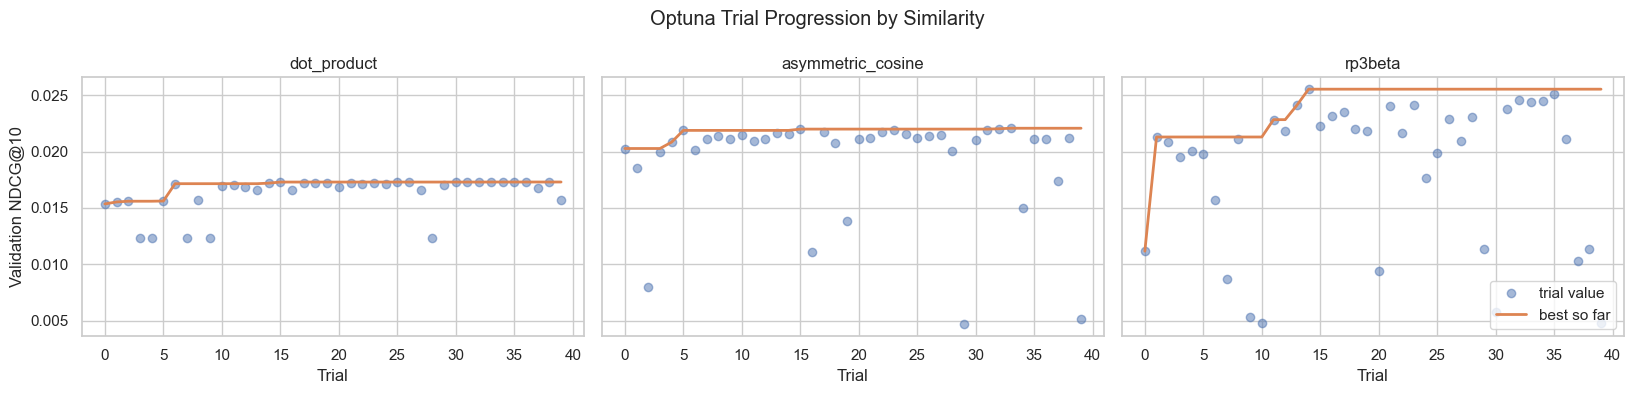

In [20]:
# Optimization progression plots (one panel per similarity)
fig, axes = plt.subplots(1, len(MODELS_TO_OPTIMIZE), figsize=(5.5 * len(MODELS_TO_OPTIMIZE), 4), sharey=True)
if len(MODELS_TO_OPTIMIZE) == 1:
    axes = [axes]

for ax, model_name in zip(axes, MODELS_TO_OPTIMIZE):
    study = studies_by_model[model_name]
    trials_df = study.trials_dataframe(attrs=("number", "value", "state"))
    completed = trials_df[trials_df["state"] == "COMPLETE"].copy().sort_values("number")

    if len(completed) == 0:
        ax.set_title(f"{model_name} (no completed trials)")
        continue

    completed["best_so_far"] = completed["value"].cummax()
    ax.plot(completed["number"], completed["value"], marker="o", linestyle="", alpha=0.5, label="trial value")
    ax.plot(completed["number"], completed["best_so_far"], linewidth=2, label="best so far")
    ax.set_title(model_name)
    ax.set_xlabel("Trial")

axes[0].set_ylabel("Validation NDCG@10")
axes[-1].legend(loc="lower right")
plt.suptitle("Optuna Trial Progression by Similarity")
plt.tight_layout()
plt.show()



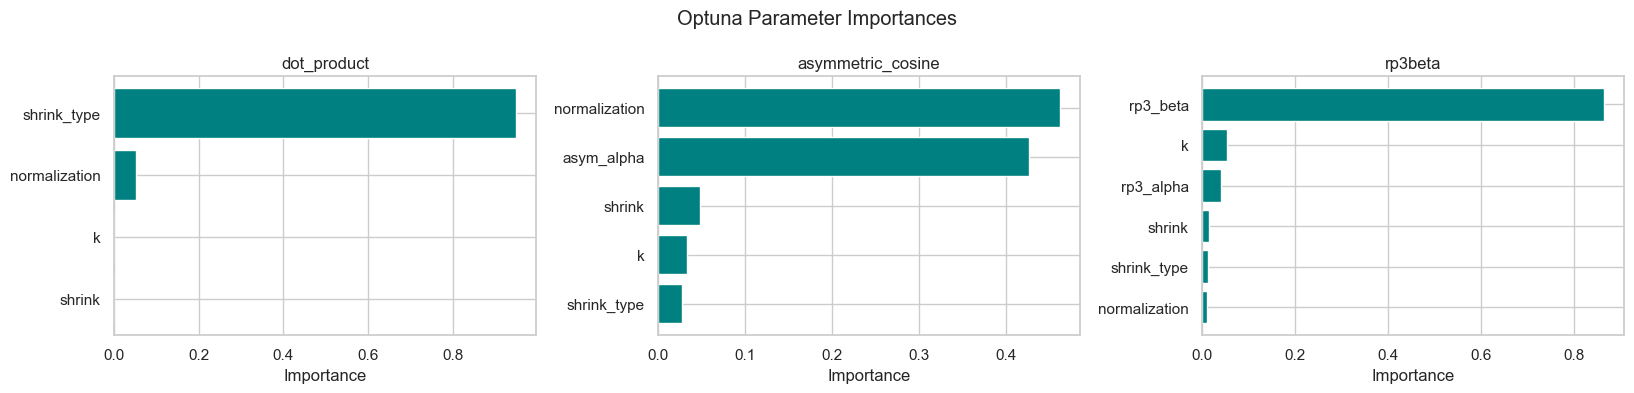

In [21]:
# Parameter importance plots (per similarity)
fig, axes = plt.subplots(1, len(MODELS_TO_OPTIMIZE), figsize=(5.5 * len(MODELS_TO_OPTIMIZE), 4))
if len(MODELS_TO_OPTIMIZE) == 1:
    axes = [axes]

for ax, model_name in zip(axes, MODELS_TO_OPTIMIZE):
    study = studies_by_model[model_name]
    try:
        importances = get_param_importances(study)
        imp_df = pd.DataFrame({"param": list(importances.keys()), "importance": list(importances.values())})
        imp_df = imp_df.sort_values("importance", ascending=True)

        ax.barh(imp_df["param"], imp_df["importance"], color="teal")
        ax.set_title(model_name)
        ax.set_xlabel("Importance")
    except Exception as e:
        ax.axis("off")
        ax.set_title(f"{model_name} (importance unavailable)")
        ax.text(0.0, 0.5, str(e), va="center", fontsize=9)

plt.suptitle("Optuna Parameter Importances")
plt.tight_layout()
plt.show()



In [22]:
# Best run summary for each similarity
best_model_trials = {model_name: studies_by_model[model_name].best_trial for model_name in MODELS_TO_OPTIMIZE}

rows = []
for model_name in MODELS_TO_OPTIMIZE:
    t = best_model_trials[model_name]
    p = t.params
    rows.append(
        {
            "model": model_name,
            "best_trial": t.number,
            "val_ndcg@10": t.value,
            "normalization": p.get("normalization", "none"),
            "k": p.get("k", np.nan),
            "shrink": p.get("shrink", np.nan),
            "shrink_type": p.get("shrink_type", np.nan),
            "alpha": p.get("asym_alpha", p.get("rp3_alpha", np.nan)),
            "beta": p.get("rp3_beta", np.nan),
        }
    )

best_runs_df = pd.DataFrame(rows).sort_values("val_ndcg@10", ascending=False).reset_index(drop=True)
best_runs_df



,model,best_trial,val_ndcg@10,normalization,k,shrink,shrink_type,alpha,beta
0,rp3beta,14,0.025526,none,398,2,stabilized,0.60,0.7
1,asymmetric_cosine,33,0.022064,bm25,500,323,additive,0.35,NaN
2,dot_product,33,0.017300,tfidf,211,7,additive,NaN,NaN


## 8) Final Evaluation on Test Set

We evaluate:
- Baselines (`Top Popular`, `Random`)
- Best tuned configuration for each item-item algorithm found in the **separate** Optuna studies

Protocol:
- Train models on `train_test` (all data up to the global test cutoff)
- Evaluate on one test target per user from `holdout_test`, using the configured GTS target strategy (`last`/`random`)

Main metric: **NDCG@10** (with Recall@10 and Precision@10 for context).



In [23]:
test_targets_eval = sample_targets(test_targets_all, max_users=TEST_EVAL_MAX_USERS, seed=TEST_EVAL_SAMPLE_SEED)

item_popularity_test, popular_items_test = build_popularity_ranking(URM_train_test)
item_user_train_test_raw = URM_train_test.T.tocsr()
item_user_train_test_by_norm = {
    norm_name: apply_interaction_normalization(item_user_train_test_raw, norm_name)
    for norm_name in NORMALIZATION_OPTIONS
}

final_rows = []

# Baselines on test targets
test_top_pop = evaluate_recommender_on_targets(
    lambda u, seen, k: recommend_top_pop_from_ranking(popular_items_test, seen, k),
    test_targets_eval,
    k=10,
)
test_top_pop["model"] = "Top Popular"
final_rows.append(test_top_pop)

test_random = evaluate_recommender_on_targets(
    lambda u, seen, k: recommend_random(u, seen, k, seed=42),
    test_targets_eval,
    k=10,
)
test_random["model"] = "Random"
final_rows.append(test_random)

# Tuned item-item models on test targets
trained_tuned_models = {}

for model_name in MODELS_TO_OPTIMIZE:
    trial = best_model_trials.get(model_name)
    if trial is None:
        continue

    p = trial.params
    normalization = p.get("normalization", "none")
    train_matrix = item_user_train_test_by_norm[normalization]

    params = {
        "k": p["k"],
        "shrink": p["shrink"],
        "shrink_type": p.get("shrink_type", "stabilized"),
    }
    if model_name == "rp3beta":
        params["alpha"] = p["rp3_alpha"]
        params["beta"] = p["rp3_beta"]
    elif model_name == "asymmetric_cosine":
        params["alpha"] = p["asym_alpha"]

    W_tuned = train_item_similarity(model_name, train_matrix, **params)
    trained_tuned_models[model_name] = W_tuned

    m = evaluate_sparse_item_model_on_targets(
        W_tuned,
        targets_df=test_targets_eval,
        k=10,
        batch_size=1024,
        fallback_items=popular_items_test,
    )
    m["model"] = f"{model_name} (tuned)"
    final_rows.append(m)

final_test_df = pd.DataFrame(final_rows)[["model", "n_users", "Precision@10", "Recall@10", "NDCG@10"]]
final_test_df = final_test_df.sort_values("NDCG@10", ascending=False).reset_index(drop=True)
final_test_df



,model,n_users,Precision@10,Recall@10,NDCG@10
0,rp3beta (tuned),4154,0.004117,0.041165,0.021907
1,asymmetric_cosine (tuned),4154,0.004117,0.041165,0.019970
2,dot_product (tuned),4154,0.003226,0.032258,0.016988
3,Top Popular,4154,0.002720,0.027203,0.013767
4,Random,4154,0.000072,0.000722,0.000308


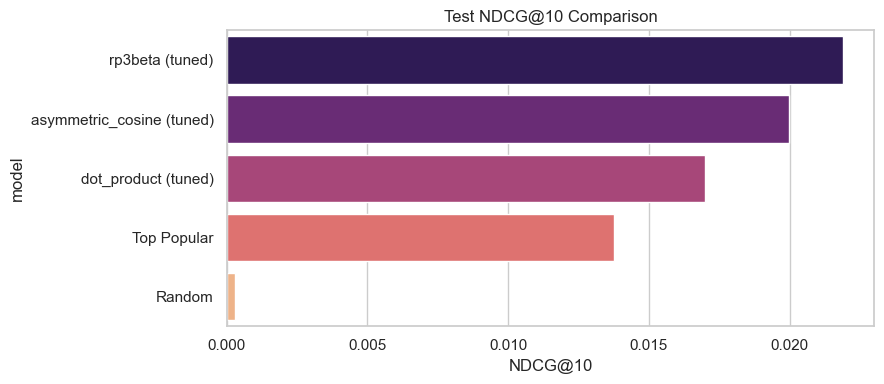

In [24]:
plt.figure(figsize=(9, 4))
sns.barplot(data=final_test_df, x="NDCG@10", y="model", hue="model", palette="magma", dodge=False, legend=False)
plt.title("Test NDCG@10 Comparison")
plt.tight_layout()
plt.show()



## 9) Recommendation Examples

For one representative user, compare:
- Top Popular
- Best tuned item-item model

Selection rule for this user:
- `< MAX_CONTEXT_ITEMS_FOR_EXAMPLE` context items in the test target profile (default: `20`)
- at least one interaction in the validation holdout window

Recommendations are generated from the user's **pre-target context** under the GTS protocol and displayed with `title` and `genres`.

For transparency, we also show the **user profile used for scoring** (context items before the target timestamp).


In [25]:
# Build metadata lookup by item_idx
item_map_df = pd.DataFrame({
    "movieId": unique_items,
    "item_idx": np.arange(len(unique_items), dtype=np.int32),
})
movie_lookup = item_map_df.merge(movies[["movieId", "title", "genres", "release_year", "release_decade", "decade_label"]], on="movieId", how="left")
movie_lookup = movie_lookup.set_index("item_idx")

# Pick best tuned item-item model by test NDCG if available
item_model_rows = final_test_df[final_test_df["model"].str.contains("tuned", regex=False)]
if len(item_model_rows) > 0:
    best_model_label = item_model_rows.iloc[0]["model"]
    best_model_name = best_model_label.replace(" (tuned)", "")
else:
    # fallback to best default model from validation
    best_model_name = item_item_df.sort_values("NDCG@10", ascending=False).iloc[0]["model"]

if best_model_name in trained_tuned_models:
    W_best = trained_tuned_models[best_model_name]
else:
    W_best = trained_default_models[best_model_name]

print("Best item-item model for examples:", best_model_name)



Best item-item model for examples: rp3beta


In [26]:
def recommend_user_with_similarity(context_items, W, k=10, fallback_items=None):
    if fallback_items is None:
        fallback_items = np.argsort(-np.asarray(W.sum(axis=0)).ravel())

    context_items = np.asarray(context_items, dtype=np.int32)
    x = _build_context_matrix([context_items], n_items=W.shape[0])

    if len(context_items) > 0:
        row = sim.dot_product(
            x,
            W,
            k=int(k),
            target_rows=np.array([0], dtype=np.int32),
            filter_cols=x,
            verbose=False,
            format_output="csr",
        ).tocsr()
    else:
        row = sp.csr_matrix((1, W.shape[0]), dtype=np.float32)

    recs = _topk_from_sparse_row(
        row.indices,
        row.data,
        k=k,
        fallback_items=fallback_items,
        forbidden_items=context_items,
    )
    return recs


def recs_to_table(rec_items):
    out = pd.DataFrame({"item_idx": rec_items})
    out = out.join(movie_lookup[["movieId", "title", "genres"]], on="item_idx")
    return out[["item_idx", "movieId", "title", "genres"]]


def context_profile_table(user_idx, target_event_idx, context_items, max_rows=30):
    context_items = np.asarray(context_items, dtype=np.int32)
    if len(context_items) == 0:
        return pd.DataFrame(columns=["item_idx", "movieId", "title", "genres", "interaction_time"])

    ctx_set = set(context_items.tolist())
    prof = interactions_global[
        (interactions_global["user_idx"] == int(user_idx))
        & (interactions_global["event_idx"] < int(target_event_idx))
        & (interactions_global["item_idx"].isin(ctx_set))
    ][["item_idx", "timestamp"]].copy()

    prof["interaction_time"] = pd.to_datetime(prof["timestamp"], unit="s")
    prof = (
        prof.drop(columns=["timestamp"])
        .sort_values("interaction_time", ascending=False)
        .drop_duplicates("item_idx", keep="first")
    )
    prof = prof.join(movie_lookup[["movieId", "title", "genres"]], on="item_idx")
    prof = prof[["item_idx", "movieId", "title", "genres", "interaction_time"]]

    if len(prof) > max_rows:
        return prof.head(max_rows).reset_index(drop=True)
    return prof.reset_index(drop=True)


# User must have validation activity (>=1 interaction in holdout_val_pool)
val_user_counts = (
    holdout_val_pool.groupby("user_idx").size().rename("n_val_items").astype(int)
)

candidate_targets = test_targets_eval.merge(
    val_user_counts,
    left_on="user_idx",
    right_index=True,
    how="inner",
)

strict_candidates = candidate_targets[candidate_targets["n_context_items"] < MAX_CONTEXT_ITEMS_FOR_EXAMPLE].copy()

if len(strict_candidates) > 0:
    chosen_df = (
        strict_candidates.sort_values(
            ["n_context_items", "n_val_items", "target_timestamp"],
            ascending=[True, False, False],
        )
        .head(1)
        .reset_index(drop=True)
    )
elif len(candidate_targets) > 0:
    print(f"No test target found with <{MAX_CONTEXT_ITEMS_FOR_EXAMPLE} context items and validation activity; using the smallest-context user with validation activity.")
    chosen_df = (
        candidate_targets.sort_values(
            ["n_context_items", "n_val_items", "target_timestamp"],
            ascending=[True, False, False],
        )
        .head(1)
        .reset_index(drop=True)
    )
else:
    chosen_df = pd.DataFrame()


if len(chosen_df) == 0:
    print("No eligible user found for recommendation example.")
else:
    row = chosen_df.iloc[0]
    u = int(row.user_idx)
    context_items = row.context_items
    target_item = int(row.target_item_idx)
    target_ts = int(row.target_timestamp)
    target_event_idx = int(row.target_event_idx)
    n_val_items = int(row.n_val_items)

    rec_pop = recommend_top_pop_from_ranking(popular_items_test, context_items, k=10)
    rec_best = recommend_user_with_similarity(context_items, W_best, k=10, fallback_items=popular_items_test)

    target_meta = movie_lookup.loc[target_item] if target_item in movie_lookup.index else None

    print()
    print(f"=== User idx: {u} (original userId: {idx_to_user[u]}) ===")
    print("Target timestamp:", pd.to_datetime(target_ts, unit="s"))
    print("Context length used for scoring:", len(context_items))
    print("Validation holdout interactions for this user:", n_val_items)
    if target_meta is not None:
        print("Held-out target:", target_meta["title"], "|", target_meta["genres"])

    profile_df = context_profile_table(u, target_event_idx, context_items, max_rows=30)
    print()
    print("User profile used for recommendation (most recent context items):")
    display(profile_df)
    if len(context_items) > len(profile_df):
        print(f"(Showing 30/{len(context_items)} context items)")

    print()
    print("Top Popular recommendations:")
    display(recs_to_table(rec_pop))

    print()
    print(f"{best_model_name} recommendations:")
    display(recs_to_table(rec_best))



=== User idx: 83253 (original userId: 83690) ===
Target timestamp: 2023-07-20 15:12:03
Context length used for scoring: 19
Validation holdout interactions for this user: 13
Held-out target: Bullet Train (2022) | Action|Mystery|Thriller

User profile used for recommendation (most recent context items):


,item_idx,movieId,title,genres,interaction_time
0,2891,195159,Spider-Man: Into the Spider-Verse (2018),Action|Adventure|Animation|Sci-Fi,2023-07-20 15:11:47
1,3563,6550,Johnny English (2003),Action|Comedy|Thriller,2023-07-20 15:11:03
2,2818,8807,Harold and Kumar Go to White Castle (2004),Adventure|Comedy,2023-07-20 15:10:40
3,2922,79134,Grown Ups (2010),Comedy,2023-07-20 15:10:09
4,6898,72171,Black Dynamite (2009),Action|Comedy,2023-07-20 15:08:56
5,2971,167746,The Lego Batman Movie (2017),Action|Animation|Comedy,2023-07-20 15:08:25
6,2062,61024,Pineapple Express (2008),Action|Comedy|Crime,2023-06-27 19:29:31
7,15,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,2023-06-27 19:28:20
8,831,72998,Avatar (2009),Action|Adventure|Sci-Fi|IMAX,2023-06-27 19:19:10
9,1437,6942,Love Actually (2003),Comedy|Drama|Romance,2023-06-27 19:18:56



Top Popular recommendations:


,item_idx,movieId,title,genres
0,161,318,"Shawshank Redemption, The (1994)",Crime|Drama
1,21,356,Forrest Gump (1994),Comedy|Drama|Romance|War
2,159,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,514,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
4,25,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
5,356,2959,Fight Club (1999),Action|Crime|Drama|Thriller
6,209,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
7,22,527,Schindler's List (1993),Drama|War
8,339,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
9,53,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi



rp3beta recommendations:


,item_idx,movieId,title,genres
0,1120,93510,21 Jump Street (2012),Action|Comedy|Crime
1,841,77561,Iron Man 2 (2010),Action|Adventure|Sci-Fi|Thriller|IMAX
2,1145,112138,22 Jump Street (2014),Action|Comedy|Crime
3,863,88140,Captain America: The First Avenger (2011),Action|Adventure|Sci-Fi|Thriller|War
4,860,86332,Thor (2011),Action|Adventure|Drama|Fantasy|IMAX
5,920,122904,Deadpool (2016),Action|Adventure|Comedy|Sci-Fi
6,819,69122,"Hangover, The (2009)",Comedy|Crime
7,881,95441,Ted (2012),Comedy|Fantasy
8,894,102903,Now You See Me (2013),Crime|Mystery|Thriller
9,749,54001,Harry Potter and the Order of the Phoenix (2007),Adventure|Drama|Fantasy|IMAX


## 10) Item-Item Visualization (UMAP)

We project item representations into 2D to inspect how the algorithm clusters movies by release era.
1. Take the best tuned item-item similarity matrix.
2. Select a subset of popular items for readability.
3. Compress with TruncatedSVD, then project with UMAP.
4. Color points by **release decade** (parsed from movie title year).
5. Label titles with a time-aware rule: one per pre-1990 decade, and one about every 3 years from 1990 onward.


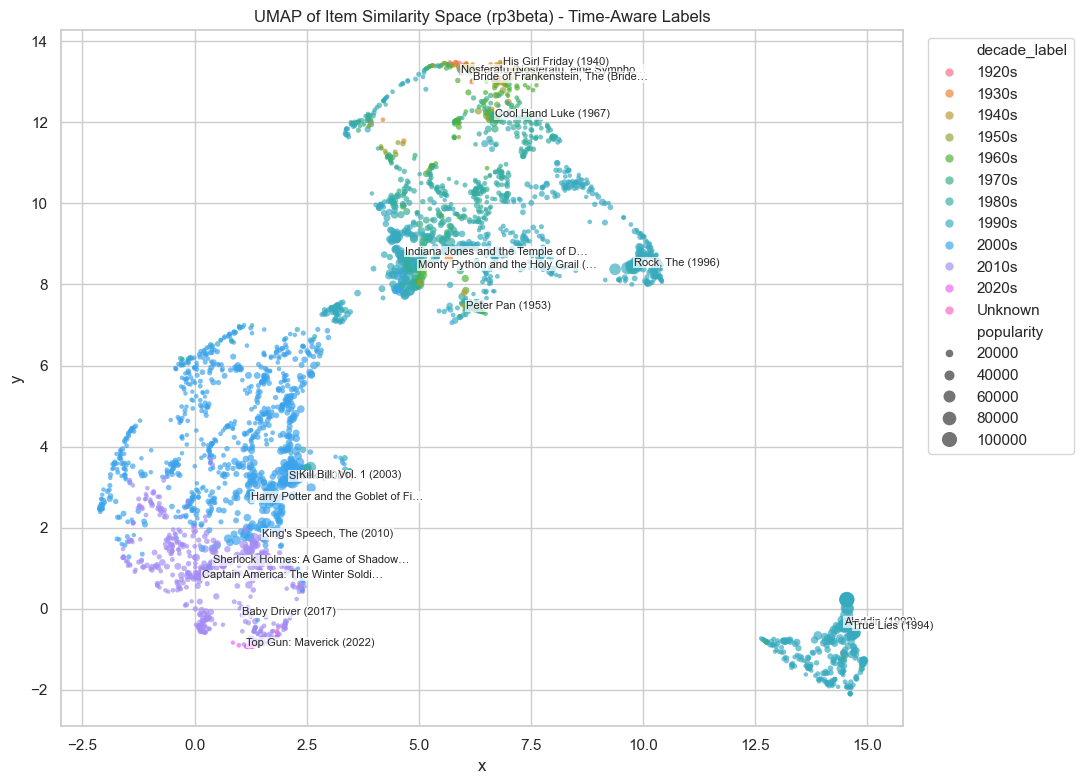

In [27]:
N_VIS_ITEMS = min(UMAP_N_VIS_ITEMS, n_items)
popular_vis_items = np.argsort(-item_popularity_test)[:N_VIS_ITEMS]

W_vis = W_best[popular_vis_items][:, popular_vis_items].tocsr()
W_vis = ((W_vis + W_vis.T) * 0.5).tocsr()

n_components_svd = min(UMAP_SVD_COMPONENTS, max(2, W_vis.shape[1] - 1))
svd = TruncatedSVD(n_components=n_components_svd, random_state=42)
item_repr = svd.fit_transform(W_vis)

umap_model = umap.UMAP(
    n_neighbors=UMAP_N_NEIGHBORS,
    min_dist=UMAP_MIN_DIST,
    metric="cosine",
    random_state=UMAP_RANDOM_SEED,
    n_jobs=1,
)
coords = umap_model.fit_transform(item_repr)

vis_df = pd.DataFrame({
    "item_idx": popular_vis_items,
    "x": coords[:, 0],
    "y": coords[:, 1],
    "popularity": item_popularity_test[popular_vis_items],
})
vis_df = vis_df.join(
    movie_lookup[["title", "genres", "release_year", "release_decade", "decade_label"]],
    on="item_idx",
)
vis_df["decade_label"] = vis_df["decade_label"].fillna("Unknown")

# Order decades chronologically in legend
known_decades = sorted([int(v) for v in vis_df["release_decade"].dropna().unique()])
ordered_labels = [f"{d}s" for d in known_decades]
if "Unknown" in vis_df["decade_label"].values:
    ordered_labels.append("Unknown")
vis_df["decade_label"] = pd.Categorical(vis_df["decade_label"], categories=ordered_labels, ordered=True)

# Time-aware labels:
# - pre-1990: 1 label per decade
# - 1990+: 1 label every ~3 years (3-year bins), to emphasize modern catalog coverage
rng = np.random.default_rng(UMAP_RANDOM_SEED)
labels = []

valid = vis_df[(vis_df["title"].notna()) & (vis_df["release_year"].notna())].copy()
valid["release_year"] = valid["release_year"].astype(int)

# Older catalog: one label per decade
old_df = valid[valid["release_year"] < UMAP_OLD_LABEL_CUTOFF_YEAR].copy()
for dec, grp in old_df.groupby("release_decade", dropna=True):
    if len(grp) == 0:
        continue
    # Favor recognizable points (top-pop), but keep a little randomness
    cand = grp.sort_values("popularity", ascending=False).head(min(20, len(grp)))
    rs = int(rng.integers(0, 1_000_000_000))
    pick = cand.sample(n=1, random_state=rs)
    pick = pick.assign(label_bucket=f"{int(dec)}s")
    labels.append(pick)

# Recent catalog: one label per 3-year bin from 1990 onward
recent_df = valid[valid["release_year"] >= UMAP_OLD_LABEL_CUTOFF_YEAR].copy()
if len(recent_df):
    recent_df["year_bin_start"] = ((recent_df["release_year"] - UMAP_OLD_LABEL_CUTOFF_YEAR) // UMAP_RECENT_LABEL_BIN_YEARS) * UMAP_RECENT_LABEL_BIN_YEARS + UMAP_OLD_LABEL_CUTOFF_YEAR
    for yb, grp in recent_df.groupby("year_bin_start", sort=True):
        if len(grp) == 0:
            continue
        cand = grp.sort_values("popularity", ascending=False).head(min(25, len(grp)))
        rs = int(rng.integers(0, 1_000_000_000))
        pick = cand.sample(n=1, random_state=rs)
        pick = pick.assign(label_bucket=f"{int(yb)}-{int(yb + UMAP_RECENT_LABEL_BIN_YEARS - 1)}")
        labels.append(pick)

labeled_titles_df = (
    pd.concat(labels, axis=0).reset_index(drop=True)
    if labels
    else pd.DataFrame(columns=list(vis_df.columns) + ["label_bucket"])
)


def short_title(t, max_len=34):
    t = str(t)
    return t if len(t) <= max_len else t[: max_len - 1] + "…"


plt.figure(figsize=(11, 8))
sns.scatterplot(
    data=vis_df,
    x="x",
    y="y",
    hue="decade_label",
    size="popularity",
    sizes=(10, 120),
    alpha=0.68,
    linewidth=0,
)

for i, row in enumerate(labeled_titles_df.itertuples(index=False)):
    dx = 0.012 * (-1 if i % 2 == 0 else 1)
    dy = 0.010 * (1 if (i // 2) % 2 == 0 else -1)
    plt.text(
        row.x + dx,
        row.y + dy,
        short_title(row.title),
        fontsize=8,
        bbox=dict(facecolor="white", alpha=0.72, edgecolor="none", pad=0.6),
    )

plt.title(f"UMAP of Item Similarity Space ({best_model_name}) - Time-Aware Labels")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


## 11) Summary & Insights

### What worked
- Item-item collaborative filtering improved over non-personalized baselines.
- RP3Beta and Asymmetric Cosine generally benefited from tuning neighborhood size, shrinkage, and regularization.
- Using a global-timestamp protocol (GTS) with `last`/`random` targets gives a stricter and more realistic temporal evaluation than user-wise splits.
- SimilariPy made it straightforward to compare multiple item-item algorithms under the same sparse pipeline.

### Practical next steps
1. Add re-ranking with novelty/diversity constraints.
2. Check different training windonws or apply some time decay strategy (training data and/or user profile) to push recency and freshness in the recommmendation. This can affect a lot models like top popular and collaborative filtering.
3. Build a hybrid model by combining collaborative scores with content features (genres, embeddings).
4. Compare against matrix factorization and neural CF architectures.

### Reproducibility Notes

- This notebook uses a global-timestamp split (GTS) with one target per user (`last` or `random`) and binary implicit interactions.
- Main runtime controls are centralized in **Global Configuration** (window sizes, target strategy, sample sizes, Optuna budget, UMAP density).
- Some evaluation cells use user subsampling for practical runtime; set those limits to `None` for full evaluation.
